In [1]:
from lib import Table, init
sc = init()
te = Table('task_events', sc, 1, 1.0)
tu = Table('task_usage', sc, 1, 1.0)

22/01/11 17:38:47 WARN Utils: Your hostname, pasokon resolves to a loopback address: 127.0.1.1; using 192.168.1.96 instead (on interface wlo1)
22/01/11 17:38:47 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/01/11 17:38:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/11 17:38:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
def avg_init(row):
    return (row, 1)

def avg_merge(old, new):
    return (old[0]+new,old[1]+1)

def avg_cmb(old, new):
    return (old[0]+new[0],old[1]+new[1])

In [18]:
# Collect the cpu requested by each process identified by the tuple (job id, task id),
# and discard the Non Available values.
sanitize = lambda x: round(float(x)*100,4)
cpu_requests = te.select(['job_id','cpu_request'])\
                     .filter(lambda x: x[1] != 'NA')\
                     .map(lambda x: (x[0],sanitize(x[1])))
cpu_req_avg = cpu_requests.combineByKey(avg_init,avg_merge, avg_cmb)\
    .mapValues(lambda x: round(x[0]/x[1],3))

In [19]:
# Same with the CPU rate
cpu_used = tu.select(['job_id','cpu_rate'])\
                   .filter(lambda x: x[1] != 'NA')\
                   .map(lambda x: (x[0],sanitize(x[1])))
cpu_used_avg = cpu_used.combineByKey(avg_init,avg_merge, avg_cmb)\
    .mapValues(lambda x: round(x[0]/x[1],3))

In [20]:
cpu_consumption = cpu_req_avg.join(cpu_used_avg)

In [21]:
cons_delta = cpu_consumption.map(lambda x: round(x[1][0]-x[1][1], 4))

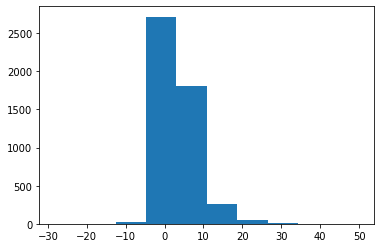

In [22]:
import matplotlib.pyplot as plt

plt.hist(cons_delta.collect());

In [25]:
cons_delta.sort(ascending=False).take(10)

AttributeError: 'PipelinedRDD' object has no attribute 'sort'